In [32]:
import pandas as pd 
import numpy as np 
import src.fold
from tqdm import tqdm 
import requests
from src.files import *
import io
from src.fold import * 
import re
from Bio.Seq import Seq
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt
import time 

%load_ext autoreload
%autoreload 2

ece_id = 'ece_26_1334'
genome_ids = ['methanoperedens_1', 'methanoperedens_2', ece_id]

# Convert the GenBank files to other file formats 
for genome_id in genome_ids:
    path = os.path.join('../data/', f'{genome_id}.gbk')
    genbank_file = GenBankFile.from_file(path)
    genbank_file.to_fasta(path.replace('.gbk', '.fa'))
    genbank_file.to_gff(path.replace('.gbk', '.gff'))

# sbatch --partition gpu --gpus 1 --wrap '/shared/software/bin/colabfold_batch --use-gpu-relax --amber --templates --num-recycle 3 ./data/ece_26_1334.fa ./alphafold'
# sbatch --partition gpu --gpus 1 --wrap '/shared/software/bin/colabfold_batch --use-gpu-relax --amber --templates --num-recycle 3 ./data/ece_26_1334_all_orfs.fa ./alphafold'
# rosettafold2 -o ./rosettafold ./data/ece_26_1334.fa

# srun foldseek easy-search ./foldseek/query/esmfold/ /shared/db/foldseek/latest/db/pdb ./foldseek/esmfold-ece_26_1334-pdb.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# srun foldseek easy-search ./foldseek/query/esmfold/ /shared/db/foldseek/latest/db/alphafold_uniprot ./foldseek/esmfold-ece_26_1334-uniprot.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# srun foldseek easy-search ./foldseek/query/alphafold/ /shared/db/foldseek/latest/db/pdb ./foldseek/alphafold-ece_26_1334-pdb.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# srun foldseek easy-search ./foldseek/query/alphafold/ /shared/db/foldseek/latest/db/alphafold_uniprot ./foldseek/alphafold-ece_26_1334-uniprot.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64


# featureCounts -p -T 64 -g ID -t CDS -a ece_26_1334.gff -s 2 -o ./metat/n_middle_2025-ece_26_1334_read_counts ./metat/n_middle_2025-ece_26_1334.bam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ! makeblastdb -in ../data/borg_family_members.faa -dbtype prot -out ../blast/databases/borg_family_members -title 'borg_family_members'

# '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
# ! blastp -query ../data/ece_26_1334.fa -db ../data/blast/databases/borg_family_members -out ../data/blast/output/ece_26_1334-borg_family_members.tsv -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
! blastp -query ../data/ece_26_1334.fa -db ../data/blast/databases/borg_family_members -out ../data/ece_26_1334-borg_family_members.tsv -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
! blastp -query ../data/ece_26_1334_all_orfs.fa -db ../data/blast/databases/borg_family_members -out ../data/ece_26_1334_all_orfs-borg_family_members.tsv -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'

In [3]:
# cols = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
# blast_df = pd.read_csv('../data/blast/output/ece_26_1334-borg_family_members.tsv', sep='\t', names=cols.split(), header=None)

In [4]:
# Want to look at transcription on the strand opposite the ORFs. 

def reverse_gff_file(path:str):
    cols = ['contig_id', 'model', 'feature_type', 'start', 'stop', 'score', 'strand', 'frame', 'description']
    gff_df = pd.read_csv(path, sep='\t', names=cols, comment='#')
    gff_df['strand'] = np.where(gff_df.strand == '-', '+', '-') # Just switch all the strand signs.
    
    output_path = path.replace('.gff', '_rev.gff')
    with open(output_path, 'w') as f:
        f.write('##gff-version  3\n')
    
    gff_df.to_csv(output_path, header=None, sep='\t', index=False, mode='a') # Append to the file which already has the header. 


reverse_gff_file('../data/ece_26_1334.gff')

In [5]:
# I am honestly a bit curious about other potential proteins on the element that Prodigal may have missed. 
start_codons = ['ATG', 'GTG', 'TTG']
start_codon_pattern = f'(?=({'|'.join(start_codons)}))' # Use lookahead to support overlapping start codons. 
stop_codons = ['TAG', 'TAA', 'TGA']
ece_seq = FASTAFile.from_file(f'../data/{ece_id}.fn').seqs[0]
ece_seq_reverse = str(Seq(ece_seq).reverse_complement())

# ece_df = FASTAFile.from_file(f'../data/{ece_id}.fa').to_df(parse_description=False)
ece_df = GenBankFile.from_file(f'../data/{ece_id}.gbk').to_df()
ece_df['id'] = [f'ece_26_1334_{id_}' for id_ in ece_df.index]

ece_stops = ece_df.stop.unique()
ece_starts = ece_df.start.unique() - 1

def get_orfs(seq, strand:str='+'):
    get_codons = lambda start: np.array([seq[i:i + 3] for i in range(start, len(seq), 3)])
    orf_df = list()
    for start_codon_match in re.finditer(start_codon_pattern, seq):
        row = {'strand':strand}
        row['start'] = start_codon_match.start()
        row['start_codon'] = seq[row['start']:row['start'] + 3]
        codons = get_codons(row['start'])

        if np.any(np.isin(codons, stop_codons)):
            stop_codon_idx = np.where(np.isin(codons, stop_codons))[0][0] # Get the first instance of a stop codon.
            nt_seq = ''.join(codons[:stop_codon_idx + 1])
            row['stop'] = row['start'] + len(nt_seq)
            row['nt_seq'] = nt_seq
            row['stop_codon'] = codons[stop_codon_idx]
            row['seq'] = str(Seq(nt_seq).translate()).replace('*', '')
            orf_df.append(row)

    orf_df = pd.DataFrame(orf_df)
    orf_df['length'] = orf_df.seq.apply(len)
    orf_df = orf_df[orf_df.length > 9].copy()
    orf_df = orf_df.sort_values('length', ascending=False).groupby('stop', as_index=False).first() # Want to get the longest sequence for each stop codon. 

    if strand == '-':
        orf_df['stop'] = len(seq) - orf_df.start 
        orf_df['start'] = orf_df.stop - orf_df.nt_seq.apply(len)
    
    return orf_df

ece_all_orfs_df = pd.concat([get_orfs(ece_seq), get_orfs(ece_seq_reverse, strand='-')]).reset_index()
ece_all_orfs_df['already_predicted'] = (ece_all_orfs_df.stop.isin(ece_stops) & (ece_all_orfs_df.strand == '+')) | (ece_all_orfs_df.start.isin(ece_starts) & (ece_all_orfs_df.strand == '-'))
assert (ece_all_orfs_df.already_predicted.sum() == len(ece_df)), 'Some of the ORFs already predicted by Prodigal were not accounted for.'
ece_all_orfs_df = ece_all_orfs_df[~ece_all_orfs_df.already_predicted].copy() # Grab the new ORFs. 

ece_all_orfs_df['gene_id'] = [f'1_{i + 1 + len(ece_df)}' for i in range(len(ece_all_orfs_df))] # Start the gene numbering at 38. 
ece_all_orfs_df = ece_all_orfs_df.set_index('gene_id')
ece_all_orfs_df['id'] = [f'ece_26_1334_all_orfs_{id_}' for id_ in ece_all_orfs_df.index]



In [6]:
ece_df = [ece_df.assign(already_predicted=True)]
ece_df += [ece_all_orfs_df[~ece_all_orfs_df.already_predicted & (ece_all_orfs_df.length > 30)].copy()]
ece_df = pd.concat(ece_df)
ece_df['product'] = ece_df['product'].fillna('hypothetical protein')


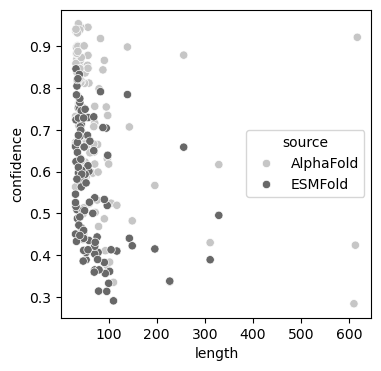

In [7]:
get_id = lambda path : re.search(r'\d+_\d+', path.replace(ece_id, '')).group(0)

figure_df = list()
for path in glob.glob('../data/structures/esmfold/*'):
    confidence, _ = fold_esm_get_confidence(path)
    figure_df.append({'confidence':confidence, 'id':get_id(path), 'source': 'ESMFold'})
for path in glob.glob('../data/structures/alphafold/*_relaxed_rank_001_alphafold2_ptm_model_*_seed_000.pdb'): # 1_9_relaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb
    confidence, _ = fold_esm_get_confidence(path)
    figure_df.append({'confidence':confidence / 100, 'id':get_id(path), 'source': 'AlphaFold'})

figure_df = pd.DataFrame(figure_df)
figure_df['length'] = figure_df['id'].map(ece_df.seq.apply(len))
figure_df = figure_df.sort_values('source')

fig, ax = plt.subplots(figsize=(4, 4))
# sns.kdeplot(figure_df, x='confidence', hue='prodigal', common_norm=False)
sns.scatterplot(figure_df, x='length', y='confidence', hue='source', ax=ax, palette='Grays')
plt.show()

In [ ]:
for input_path in glob.glob('../data/structures/esmfold/*'):
    if 'trimmed' in input_path:
        continue
    fold_trim_structure(input_path, min_b_score=0.5, save=True)

# For Foldseek, should be using the relaxed AlphaFold structure for folding. Also should make sure to use the most highly-ranked model. 
for input_path in glob.glob('../data/structures/alphafold/*pdb'):
    if ('trimmed' in input_path) or (not (('_relaxed_' in input_path) and ('rank_001' in input_path))):
        continue
    gene_id = '_'.join(os.path.basename(input_path).split('_')[:2])
    output_path = os.path.join(os.path.dirname(input_path), f'{gene_id}_trimmed.pdb')
    if not os.path.exists(output_path):
        fold_trim_structure(input_path, output_path=output_path, min_b_score=50, save=True)


In [9]:
def load_foldseek(path, max_e_value:int=1):
    fields = 'query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage'.split(',')
    foldseek_df = pd.read_csv(path, sep='\t') #, names=fields)
    foldseek_df = foldseek_df[foldseek_df['evalue'] < max_e_value].copy()
    foldseek_df = foldseek_df.sort_values('evalue')
    return foldseek_df

foldseek_df = list()
for path in glob.glob('../data/foldseek/*'):
    database, source = path.split('-')[-1].replace('.tsv', ''), path.split('-')[0]
    foldseek_df.append(load_foldseek(path).assign(database=database, source=source))
foldseek_df = pd.concat(foldseek_df)
foldseek_df['gene_id'] = foldseek_df['query'].apply(get_id)
foldseek_df['gene_number'] = foldseek_df.gene_id.apply(lambda id_ : int(id_.split('_')[1]))
foldseek_df['original_prediction'] = foldseek_df.gene_number <= 38

print('Num. proteins with reasonable Foldseek hits:', foldseek_df.gene_id.nunique())
print('Num. original proteins with reasonable Foldseek hits:', foldseek_df[foldseek_df.original_prediction].gene_id.nunique(), end='\n\n')

for gene_id in foldseek_df.gene_id.unique():
    print(gene_id)

# 1_47 https://www.nature.com/articles/nchembio.2359

Num. proteins with reasonable Foldseek hits: 15
Num. original proteins with reasonable Foldseek hits: 13

1_17
1_12
1_38
1_1
1_28
1_47
1_35
1_32
1_20
1_25
1_37
1_26
1_325
1_2
1_3


In [10]:
def print_foldseek_info(gene_id:str, foldseek_df:pd.DataFrame=foldseek_df, max_e_value:float=None):
    df = foldseek_df[foldseek_df.gene_id == gene_id].sort_values('evalue').copy()
    if max_e_value is not None:
        df = df[df.evalue < max_e_value]
    for row in df.itertuples():
        print(row.taxname, row.theader, f'E-value {row.evalue}')
        # print(row.taxname, f'({row.taxlineage})', row.theader, f'E-value {row.evalue}')
        print('target alignment:', f'{row.tstart} - {row.tend} ({row.tcov * 100:.2f}%)')
        print('query alignment:', f'{row.qstart} - {row.qend} ({row.qcov * 100:.2f}%)')
        print()

print_foldseek_info('1_35')

Chloroflexi bacterium RBG_13_46_9 AF-A0A1F8LM89-F1-model_v4 Uncharacterized protein E-value 2.66e-11
target alignment: 13 - 244 (92.80%)
query alignment: 13 - 239 (92.30%)

Bacillus cytotoxicus AF-A0A8A9GN58-F1-model_v4 ATP-binding protein E-value 5.196e-11
target alignment: 2 - 193 (91.90%)
query alignment: 15 - 234 (89.40%)

Bacillus cytotoxicus NVH 391-98 AF-A7GVR0-F1-model_v4 Uncharacterized protein E-value 5.868e-11
target alignment: 2 - 193 (91.90%)
query alignment: 15 - 234 (89.40%)

Bacillus thuringiensis AF-A0A6I2AMP5-F1-model_v4 Uncharacterized protein E-value 5.868e-11
target alignment: 3 - 198 (98.00%)
query alignment: 16 - 239 (91.10%)

Methanohalophilus sp. RSK AF-A0A3M9LRF9-F1-model_v4 Uncharacterized protein E-value 7.956e-11
target alignment: 10 - 184 (95.10%)
query alignment: 17 - 208 (78.00%)

Bacillus cytotoxicus AF-A0A8A9H090-F1-model_v4 ATP-binding protein E-value 8.986e-11
target alignment: 2 - 193 (91.90%)
query alignment: 15 - 234 (89.40%)

Candidatus Thorarcha

In [ ]:
# Not super happy with the results of Foldseek queries against PDB and UniProt. Going to try against the BFVD. 

def foldseek_submit_query(path:str):
    url = 'https://search.foldseek.com/api/ticket'
    with open(path, 'rb') as f:
        files = { 'q': f }
        data = [('mode', '3diaa'),
            ('database[]', 'BFVD'),
            ('database[]', 'afdb50'),
            ('database[]', 'afdb-proteome'),
            ('database[]', 'afdb-swissprot'),
            ('database[]', 'bfmd'),
            ('database[]', 'cath50'),
            ('database[]', 'mgnify_esm30'),
            ('database[]', 'pdb100'),
            ('database[]', 'gmgcl_id')]
        result = requests.post(url, files=files, data=data)
        if result.status_code != 200:
            print(f'foldseek_submit_query: Failed on {path}. {result.text}')
            return None
        return result.json()['id']
    
def foldseek_check_complete(job_id):
    url = f'https://search.foldseek.com/api/ticket/{job_id}'
    result = requests.get(url).json()
    return result['status'] == 'COMPLETE'


def foldseek_retrieve_results(job_id:str, output_path:str=None):
    url = f'https://search.foldseek.com/api/result/download/{job_id}'
    cmd = f'curl -o {output_path} {url}'
    subprocess.run(cmd, shell=True, check=True, stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)

output_dir = '../data/foldseek/esmfold/'
gene_ids = [f'1_{i}' for i in range(1, 39)]
paths = [os.path.join('../data/structures/esmfold/', f'{gene_id}_trimmed.pdb') for gene_id in gene_ids]
paths = [path for path in paths if os.path.exists(path)]

for path in tqdm(paths, desc='foldseek_search'):
    output_file_name = os.path.basename(path).replace('.pdb', '.tar.gz')
    output_path = os.path.join(output_dir, output_file_name)
    if os.path.exists(output_path):
        continue

    job_id = foldseek_submit_query(path)
    if job_id is not None:
        while not foldseek_check_complete(job_id):
            time.sleep(10)
        foldseek_retrieve_results(job_id, output_path=output_path)




foldseek_search:   0%|          | 0/29 [00:00<?, ?it/s]

foldseek_search:  10%|█         | 3/29 [01:31<14:00, 32.34s/it]

In [12]:
# Also trying annotation with BLAST against NCBI and Borg proteins. 
# None of the non-Prodigal predictions had any hits in NCBI. 
blast_df = BLASTFileJSON().from_file('../data/ncbi-ece_26_1334.json').to_df()
blast_df['database'] = 'ncbi'

def load_blast(path):
    cols = 'qseqid sseqid pident length A0A4Z0H468mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
    blast_df = pd.read_csv(path, sep='\t', names=cols.split())
    blast_df = blast_df.rename(columns={'qseqid':'id', 'sseqid':'subject_id', 'qstart':'query_alignment_start', 'qend':'query_alignment_stop'})
    blast_df = blast_df.rename(columns={'length':'alignment_length', 'bitscore':'bit_score', 'sstart':'subject_alignment_start', 'send':'subject_alignment_stop'})
    blast_df = blast_df.rename(columns={'pident':'identity', 'evalue':'e_value', 'qlen':'query_length', 'slen':'subject_length'})
    return blast_df.drop(columns=['gapopen', 'qcovhsp'])

blast_df = pd.concat([blast_df, load_blast('../data/ece_26_1334_all_orfs-borg_family_members.tsv').assign(database='borgs')])
blast_df = pd.concat([blast_df, load_blast('../data/ece_26_1334-borg_family_members.tsv').assign(database='borgs')])
blast_df['id'] = blast_df['id'].str.replace(ece_id, '1')
blast_df['gene_number'] = blast_df['id'].apply(lambda id_ : int(id_.split('_')[1]))

blast_df = blast_df[blast_df.bit_score > 40].copy()
print('Num. proteins with BLAST hits:', blast_df['id'].nunique())

Num. proteins with BLAST hits: 12


In [13]:
blast_df[blast_df.gene_number == 27]#.subject_id.tolist()

,subject_id,id,subject_description,subject_taxon,subject_taxonomy_id,bit_score,e_value,identity,positive,subject_alignment_start,...,n_gaps,alignment_length,query_seq,subject_seq,subject_length,query_length,alignment,database,A0A4Z0H468mismatch,gene_number
236,MDO9354834,1_27,hypothetical protein [Solirubrobacteraceae bac...,Solirubrobacteraceae bacterium,2586742.0,67.3958,7.867810e-08,98.0,177.0,67,...,44.0,374,ITTDKTAYNLGDII-FENYTIANADTYN--FLYTIRTYDENNILIS...,ISFNKSFYSLYDVINFSYHIMDNSTTHNTYYIKTIQTEKS----TG...,407,610,I+ +K+ Y+L D+I F + + N+ T+N ++ TI+T ...,ncbi,NaN,27
